In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold

C:\Users\Napon\AppData\Local\Temp\ipykernel_30912\2572126352.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_excel('Data_Fatlim_Expanded_E.xlsx')
#df = df.dropna()
print(list(df.columns))
pdf = df[['set','s11a', 's22a', 's33a', 't12a', 't13a', 't23a', 's11m', 's22m', 's33m', 't12m', 't13m', 't23m', 'fi11', 'fi22', 'fi33', 'fi12', 'fi13', 'fi23', 'Rm', 'Re', 'f-1', 'f0', 't-1', 't0', 'walker']]
print(pdf.shape)

pdf_AMSD = pdf[pdf['set'] == 'AMSD25'].drop(columns=['set'])
pdf_Fatlim = pdf[pdf['set'].isin(['Fatlim', 'Uniaxial'])].drop(columns=['set'])

train_x = pdf_AMSD.copy()
test_x = pdf_Fatlim.copy()
train_y = pd.DataFrame(train_x.pop('f-1'), columns = ['f-1']) 
test_y = pd.DataFrame(test_x.pop('f-1'), columns = ['f-1'])

phy_train_pdfy = pd.DataFrame(train_x.pop('walker'), columns = ['walker'])
phy_test_pdfy = pd.DataFrame(test_x.pop('walker'), columns = ['walker'])

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

x_train_tensor = torch.tensor(np.array(train_x), dtype=torch.float32).requires_grad_(True).to('cuda')
y_train_tensor = torch.tensor(np.array(train_y), dtype=torch.float32).requires_grad_(True).to('cuda')
x_test_tensor = torch.tensor(np.array(test_x), dtype=torch.float32).requires_grad_(True).to('cuda')

print(x_train_tensor.shape, y_train_tensor.shape)
print(x_test_tensor.shape)

['Trans', 'index', 'set', 's11a', 's22a', 's33a', 's11m', 's22m', 's33m', 't12a', 't13a', 't23a', 't12m', 't13m', 't23m', 'fi11', 'fi22', 'fi33', 'fi12', 'fi13', 'fi23', 'propo', 'Testing', 'mat', 'matgr', 'Rm', 'Re', 'f-1', 'f0', 'b-1', 'b0', 'rb-1', 't-1', 't0', 'Nx', 'gramWalker', 'gramWalker_ann', 'gramWalkerE_ann', 'mises_a', 'mises_m', 'mises', 'misesE', 'E_Mpa', 'poi', 'walkerE', 'walkerE_ann', 'walker_ann', 'walker', 'SWT', 'smith', 'soderberg', 'ASME', 'Bagci', 'Gerber', 'fNP_Bishop', 'fNP_Itoh', 'psi_max', 'S_eq', 'f-1_max', 'S_eq_mises_max', 'WS_a', 'WS_m']
(1732, 26)
(236, 23) (236, 1)
(1496, 23) (1496, 1)
torch.Size([236, 23]) torch.Size([236, 1])
torch.Size([1496, 23])


In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()

        #self.normalization = nn.BatchNorm1d(input_size)

        self.fc_layers = nn.Sequential(

            nn.Linear(input_size, 200),
            nn.ReLU(),

            nn.Linear(200, 200),
            nn.ReLU(),

            nn.Linear(200, 200),
            nn.ReLU(),

            nn.Linear(200, 200),
            nn.ReLU(),

            nn.Linear(200, 200),
            nn.ReLU(),

            nn.Linear(200, output_size)
        )
    
    def forward(self, x):

        #out = self.normalization(x)
        out = self.fc_layers(x)

        return out

Epoch [1000/1000], Loss: 8.33 Validation MSE for fold 1: 19.08
Epoch [1000/1000], Loss: 5.58 Validation MSE for fold 2: 24.34
Epoch [1000/1000], Loss: 6.39 Validation MSE for fold 3: 28.12
Epoch [1000/1000], Loss: 7.44 Validation MSE for fold 4: 30.40
Epoch [1000/1000], Loss: 7.60 Validation MSE for fold 5: 32.79
Epoch [1000/1000], Loss: 6.30 Validation MSE for fold 6: 19.80
Average MSE: 25.76


(69.36426544189453, 658.581787109375)

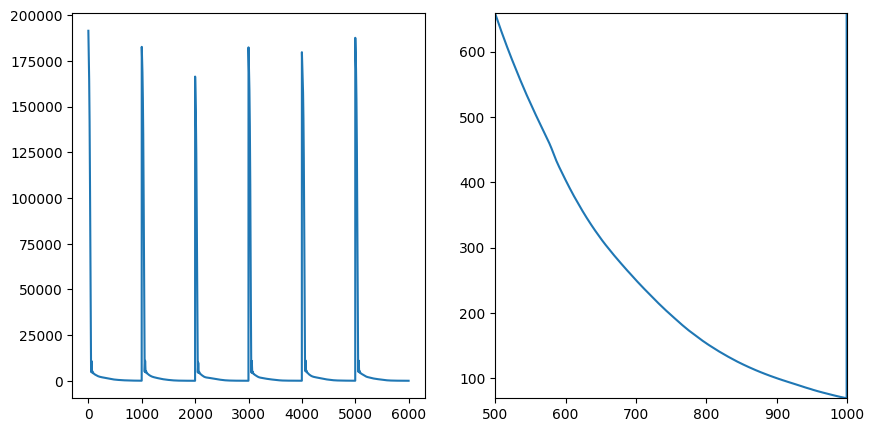

In [4]:
seed = 777
torch.manual_seed(seed)

lossesNN = []
lossesPhy = []
total_losses = []

kf = KFold(n_splits = 6, shuffle=True, random_state=seed)
results = []

for fold, (train_index, val_index) in enumerate(kf.split(x_train_tensor)):
    print(f"FOLD {fold + 1} ",end='')

    X_train, X_val = x_train_tensor[train_index], x_train_tensor[val_index]
    y_train, y_val = y_train_tensor[train_index], y_train_tensor[val_index]


    model = NeuralNetwork(23, 1).to('cuda')
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    epochs = 1000
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        Se_pred = model(X_train.to('cuda'))
        loss1 = loss(Se_pred, y_train.to('cuda'))
        lossesNN.append(loss1.item())
        loss1.backward(retain_graph=True)
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'\rEpoch [{epoch + 1}/{epochs}], Loss: {(loss1.item())**0.5:.2f}', end=' ')
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val.to('cuda'))
        val_loss = loss(val_outputs, y_val.to('cuda'))
        results.append(val_loss**0.5)
        print(f"Validation MSE for fold {fold + 1}: {val_loss**0.5:.2f}")

results = [result.cpu().numpy() for result in results]
results = np.array(results)

average_mse = np.mean(results)
print(f"Average MSE: {average_mse:.2f}")



fig_1, axs = plt.subplots(1, 2, figsize=(10, 5))
#fig_1.suptitle('Normal plot')
axs[0].plot(lossesNN, label='Training Loss')

axs[1].plot(lossesNN, label='Training Loss')
axs[1].set_xlim((epochs*0.5), epochs)
axs[1].set_ylim( lossesNN[int(epochs-1)], lossesNN[int(epochs*0.5)])
#axs[1].set_ylim( lossesNN[int(epochs*0.1)] , int(lossesNN[epochs-1]))


Text(10, 80, 'Std: 10.229')

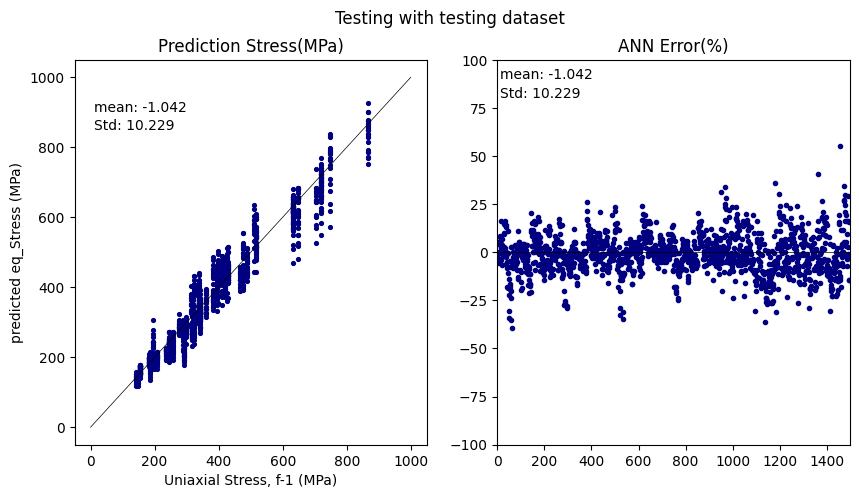

In [5]:
with torch.no_grad():
    output = model(x_test_tensor)
    output = output.to('cpu')  
    
Y_pred = output.detach().numpy()

prediction = pd.DataFrame(Y_pred, columns = ['Y_pred'])
prediction['f-1'] = np.array(test_y)
prediction['error(%)'] = ((prediction['Y_pred']-prediction['f-1'])/prediction['f-1'])*100

fig_3, axs = plt.subplots(1, 2, figsize=(10, 5))
fig_3.suptitle('Testing with testing dataset')
axs[0].scatter(prediction['f-1'], prediction['Y_pred'], s=30 , marker='.', color='navy')
axs[0].plot([1000,0],[1000,0],'-',color='black', linewidth=0.5)
axs[0].set_title("Prediction Stress(MPa)")
axs[0].text(10,900,f"mean: {prediction['error(%)'].mean():.3f}",fontsize=10)
axs[0].text(10,850,f"Std: {prediction['error(%)'].std():.3f}",fontsize=10)
axs[0].set(xlabel='Uniaxial Stress, f-1 (MPa)', ylabel='predicted eq_Stress (MPa)')

axs[1].plot(prediction['error(%)'] ,'.', color='navy')
axs[1].plot([0,1700],[0,0],'-',color='black', linewidth=0.5)
axs[1].set_xlim([0, test_y.shape[0]])
axs[1].set_ylim([-100, 100])
axs[1].set_title("ANN Error(%)")
axs[1].text(10,90,f"mean: {prediction['error(%)'].mean():.3f}",fontsize=10)
axs[1].text(10,80,f"Std: {prediction['error(%)'].std():.3f}",fontsize=10)

Text(10, 80, 'Std: 3.510')

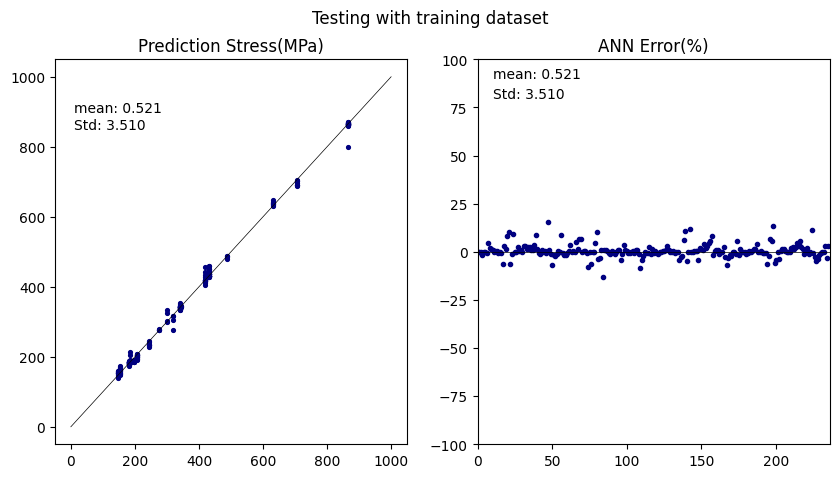

In [6]:
with torch.no_grad():
    output = model(x_train_tensor)
    output = output.to('cpu')  
    
Y_pred = output.detach().numpy()

prediction = pd.DataFrame(Y_pred, columns = ['Y_pred'])
prediction['f-1'] = np.array(train_y)
prediction['error(%)'] = ((prediction['Y_pred']-prediction['f-1'])/prediction['f-1'])*100

fig_3, axs = plt.subplots(1, 2, figsize=(10, 5))
fig_3.suptitle('Testing with training dataset')
axs[0].scatter(prediction['f-1'], prediction['Y_pred'], s=30 , marker='.', color='navy')
axs[0].plot([1000,0],[1000,0],'-',color='black', linewidth=0.5)
axs[0].set_title("Prediction Stress(MPa)")
axs[0].text(10,900,f"mean: {prediction['error(%)'].mean():.3f}",fontsize=10)
axs[0].text(10,850,f"Std: {prediction['error(%)'].std():.3f}",fontsize=10)

axs[1].plot(prediction['error(%)'] ,'.', color='navy')
axs[1].plot([0,1700],[0,0],'-',color='black', linewidth=0.5)
axs[1].set_xlim([0, train_y.shape[0]])
axs[1].set_ylim([-100, 100])
axs[1].set_title("ANN Error(%)")
axs[1].text(10,90,f"mean: {prediction['error(%)'].mean():.3f}",fontsize=10)
axs[1].text(10,80,f"Std: {prediction['error(%)'].std():.3f}",fontsize=10)

PINN

In [4]:
Physic_tensor = torch.tensor(np.array(phy_train_pdfy), dtype=torch.float32).to('cuda')
Physic_tensor = Physic_tensor.view(phy_train_pdfy.shape[0], 1)
print(Physic_tensor.shape)

torch.Size([236, 1])


Epoch [1000/1000], Loss: 76.83 NNL: 54.04, PHYL: 54.62 Validation MSE for fold 1: 48.63
Epoch [1000/1000], Loss: 77.76 NNL: 54.54, PHYL: 55.43 Validation MSE for fold 2: 42.17
Epoch [1000/1000], Loss: 76.27 NNL: 53.80, PHYL: 54.06 Validation MSE for fold 3: 45.98
Epoch [1000/1000], Loss: 72.54 NNL: 51.00, PHYL: 51.58 Validation MSE for fold 4: 55.90
Epoch [1000/1000], Loss: 74.54 NNL: 52.43, PHYL: 52.99 Validation MSE for fold 5: 54.16
Epoch [1000/1000], Loss: 69.44 NNL: 48.69, PHYL: 49.50 Validation MSE for fold 6: 67.84
Average MSE: 52.45


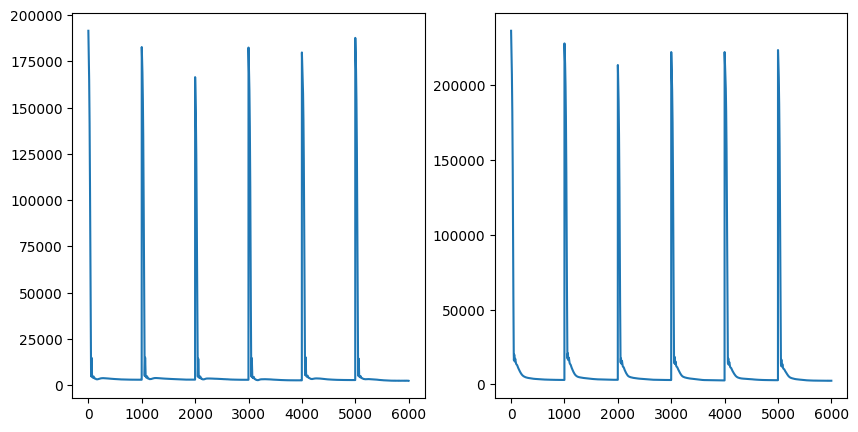

In [16]:
seed = 777
torch.manual_seed(seed)

lossesNN = []
lossesPhy = []
total_losses = []

kf = KFold(n_splits = 6, shuffle=True, random_state=seed)
results = []

for fold, (train_index, val_index) in enumerate(kf.split(x_train_tensor)):
    print(f"FOLD {fold + 1} ",end='')

    X_train, X_val = x_train_tensor[train_index], x_train_tensor[val_index]
    y_train, y_val = y_train_tensor[train_index], y_train_tensor[val_index]
    y__phy_train, y_phy_val = Physic_tensor[train_index], Physic_tensor[val_index]

    model = NeuralNetwork(23, 1).to('cuda')
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    epochs = 1000
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        Se_pred = model(X_train.to('cuda'))

        loss1 = loss(Se_pred, y_train.to('cuda'))
        loss2 = loss(Se_pred, y__phy_train.to('cuda'))
        total_loss = 1*loss1 + 1*loss2

        lossesNN.append(loss1.item())
        lossesPhy.append(loss2.item())
        #loss1.backward(retain_graph=True)
        total_loss.backward(retain_graph=True)
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'\rEpoch [{epoch+1}/{epochs}], Loss: {total_loss.item()**0.5:.2f} NNL: {loss1.item()**0.5:.2f}, PHYL: {loss2.item()**0.5:.2f}', end=' ')
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val.to('cuda'))
        val_loss = loss(val_outputs, y_val.to('cuda'))
        results.append(val_loss**0.5)
        print(f"Validation MSE for fold {fold + 1}: {val_loss**0.5:.2f}")


results = [result.cpu().numpy() for result in results]
results = np.array(results)

average_mse = np.mean(results)
print(f"Average MSE: {average_mse:.2f}")



fig_1, axs = plt.subplots(1, 2, figsize=(10, 5))
#fig_1.suptitle('Normal plot')
axs[0].plot(lossesNN, label='Training Loss')

#axs[1].plot(lossesNN, label='ANN Loss')
axs[1].plot(lossesPhy, label='PHY Loss')
#axs[1].set_xlim((epochs*0.5), epochs)
#axs[1].set_ylim( lossesNN[int(epochs-1)], lossesNN[int(epochs*0.5)])
#axs[1].set_ylim( lossesNN[int(epochs*0.1)] , int(lossesNN[epochs-1]))

            Y_pred          f-1     error(%)
count  1496.000000  1496.000000  1496.000000
mean    402.430695   388.103178     4.439264
std     174.570419   168.052559    14.474544
min     102.968651   141.461202   -36.491716
25%     273.173157   275.000000    -4.223048
50%     361.742279   343.000000     3.959956
75%     494.810226   475.603831    11.417335
max     915.191406   866.000000    79.926888


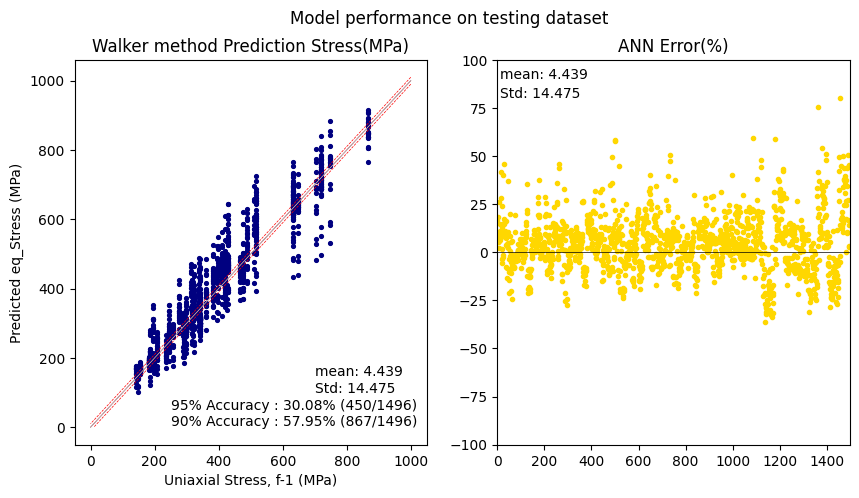

In [17]:
with torch.no_grad():
    output = model(x_test_tensor)
    output = output.to('cpu')  
    
Y_pred = output.detach().numpy()

prediction = pd.DataFrame(Y_pred, columns = ['Y_pred'])
prediction['f-1'] = np.array(test_y)
prediction['error(%)'] = ((prediction['Y_pred']-prediction['f-1'])/prediction['f-1'])*100

temp_error = prediction['error(%)']
filtered_data5 = temp_error[(temp_error >= -5) & (temp_error <= 5)]
filtered_data10 = temp_error[(temp_error >= -10) & (temp_error <= 10)]

fig_3, axs = plt.subplots(1, 2, figsize=(10, 5))
fig_3.suptitle('Model performance on testing dataset')
axs[0].scatter(prediction['f-1'], prediction['Y_pred'], s=30 , marker='.', color='navy')
axs[0].plot([1000,0],[1000,0],'-',color='black', linewidth=0.5)
axs[0].set_title("Walker method Prediction Stress(MPa)")
axs[0].text(700,150,f"mean: {prediction['error(%)'].mean():.3f}",fontsize=10)
axs[0].text(700,100,f"Std: {prediction['error(%)'].std():.3f}",fontsize=10)
axs[0].set(xlabel='Uniaxial Stress, f-1 (MPa)', ylabel='Predicted eq_Stress (MPa)')
axs[0].plot([1000,0],[1000,0],'-',color='pink', linewidth=0.5)
axs[0].plot([1000,0],[1010,10],'--',color='red', linewidth=0.5)
axs[0].plot([1000,10],[990,0],'--',color='red', linewidth=0.5)
axs[0].text(250,50,f"95% Accuracy : {filtered_data5.count()/test_x.shape[0]*100:.2f}% ({filtered_data5.count()}/{test_x.shape[0]})",fontsize=10)
axs[0].text(250,5,f"90% Accuracy : {filtered_data10.count()/test_x.shape[0]*100:.2f}% ({filtered_data10.count()}/{test_x.shape[0]})",fontsize=10)

axs[1].plot(prediction['error(%)'] ,'.', color='gold')
axs[1].plot([0,1700],[0,0],'-',color='black', linewidth=0.5)
axs[1].set_xlim([0, test_y.shape[0]])
axs[1].set_ylim([-100, 100])
axs[1].set_title("ANN Error(%)")
axs[1].text(10,90,f"mean: {prediction['error(%)'].mean():.3f}",fontsize=10)
axs[1].text(10,80,f"Std: {prediction['error(%)'].std():.3f}",fontsize=10)

print(prediction.describe())

Text(10, 80, 'Std: 14.782')

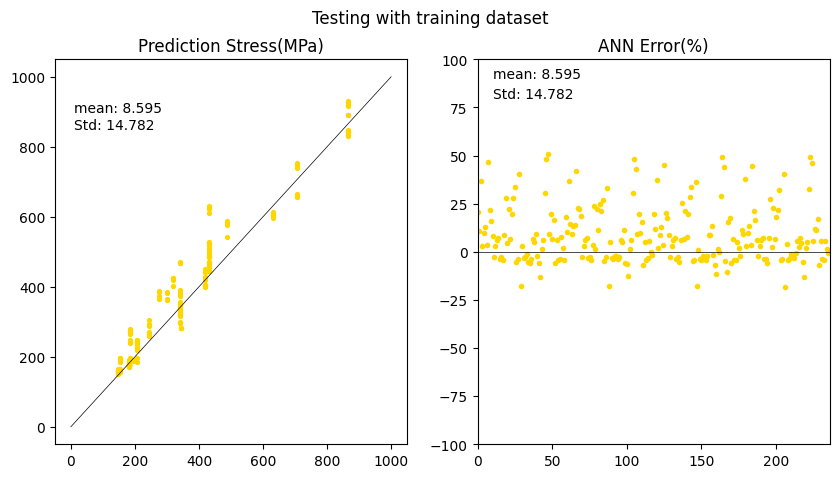

In [10]:
with torch.no_grad():
    output = model(x_train_tensor)
    output = output.to('cpu')  
    
Y_pred = output.detach().numpy()

prediction = pd.DataFrame(Y_pred, columns = ['Y_pred'])
prediction['f-1'] = np.array(train_y)
prediction['error(%)'] = ((prediction['Y_pred']-prediction['f-1'])/prediction['f-1'])*100

fig_3, axs = plt.subplots(1, 2, figsize=(10, 5))
fig_3.suptitle('Testing with training dataset')
axs[0].scatter(prediction['f-1'], prediction['Y_pred'], s=30 , marker='.', color='gold')
axs[0].plot([1000,0],[1000,0],'-',color='black', linewidth=0.5)
axs[0].set_title("Prediction Stress(MPa)")
axs[0].text(10,900,f"mean: {prediction['error(%)'].mean():.3f}",fontsize=10)
axs[0].text(10,850,f"Std: {prediction['error(%)'].std():.3f}",fontsize=10)

axs[1].plot(prediction['error(%)'] ,'.', color='gold')
axs[1].plot([0,1700],[0,0],'-',color='black', linewidth=0.5)
axs[1].set_xlim([0, train_y.shape[0]])
axs[1].set_ylim([-100, 100])
axs[1].set_title("ANN Error(%)")
axs[1].text(10,90,f"mean: {prediction['error(%)'].mean():.3f}",fontsize=10)
axs[1].text(10,80,f"Std: {prediction['error(%)'].std():.3f}",fontsize=10)

Epoch [1000/1000], Loss: 33.64 NNL: 12.94, PHYL: 98.20 Validation MSE for fold 1: 18.97
Epoch [1000/1000], Loss: 33.44 NNL: 11.33, PHYL: 99.48 Validation MSE for fold 2: 23.80
Epoch [1000/1000], Loss: 33.12 NNL: 12.12, PHYL: 97.45 Validation MSE for fold 3: 24.33
Epoch [1000/1000], Loss: 31.51 NNL: 11.77, PHYL: 92.44 Validation MSE for fold 4: 29.02
Epoch [1000/1000], Loss: 32.69 NNL: 12.71, PHYL: 95.25 Validation MSE for fold 5: 36.46
Epoch [1000/1000], Loss: 29.99 NNL: 10.76, PHYL: 88.51 Validation MSE for fold 6: 22.13
Average MSE: 25.78


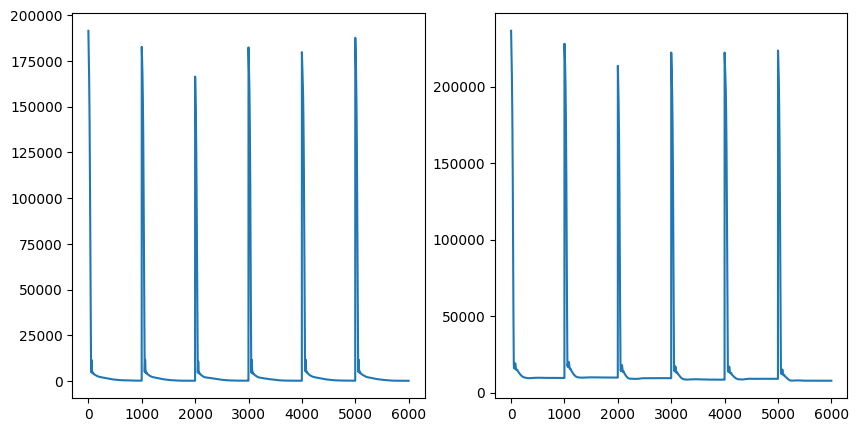

In [12]:
seed = 777
torch.manual_seed(seed)

lossesNN = []
lossesPhy = []
total_losses = []

kf = KFold(n_splits = 6, shuffle=True, random_state=seed)
results = []

for fold, (train_index, val_index) in enumerate(kf.split(x_train_tensor)):
    print(f"FOLD {fold + 1} ",end='')

    X_train, X_val = x_train_tensor[train_index], x_train_tensor[val_index]
    y_train, y_val = y_train_tensor[train_index], y_train_tensor[val_index]
    y__phy_train, y_phy_val = Physic_tensor[train_index], Physic_tensor[val_index]

    model = NeuralNetwork(23, 1).to('cuda')
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    epochs = 1000
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        Se_pred = model(X_train.to('cuda'))

        loss1 = loss(Se_pred, y_train.to('cuda'))
        loss2 = loss(Se_pred, y__phy_train.to('cuda'))
        total_loss = 1*loss1 + 0.1*loss2

        lossesNN.append(loss1.item())
        lossesPhy.append(loss2.item())
        #loss1.backward(retain_graph=True)
        total_loss.backward(retain_graph=True)
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'\rEpoch [{epoch+1}/{epochs}], Loss: {total_loss.item()**0.5:.2f} NNL: {loss1.item()**0.5:.2f}, PHYL: {loss2.item()**0.5:.2f}', end=' ')
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val.to('cuda'))
        val_loss = loss(val_outputs, y_val.to('cuda'))
        results.append(val_loss**0.5)
        print(f"Validation MSE for fold {fold + 1}: {val_loss**0.5:.2f}")


results = [result.cpu().numpy() for result in results]
results = np.array(results)

average_mse = np.mean(results)
print(f"Average MSE: {average_mse:.2f}")



fig_1, axs = plt.subplots(1, 2, figsize=(10, 5))
#fig_1.suptitle('Normal plot')
axs[0].plot(lossesNN, label='Training Loss')

#axs[1].plot(lossesNN, label='ANN Loss')
axs[1].plot(lossesPhy, label='PHY Loss')
#axs[1].set_xlim((epochs*0.5), epochs)
#axs[1].set_ylim( lossesNN[int(epochs-1)], lossesNN[int(epochs*0.5)])
#axs[1].set_ylim( lossesNN[int(epochs*0.1)] , int(lossesNN[epochs-1]))

            Y_pred          f-1     error(%)
count  1496.000000  1496.000000  1496.000000
mean    384.326294   388.103178    -0.692017
std     166.545731   168.052559     9.829065
min     114.992775   141.461202   -37.226782
25%     250.772758   275.000000    -6.577883
50%     351.522736   343.000000    -0.636981
75%     467.180550   475.603831     4.883922
max     911.153259   866.000000    55.510916


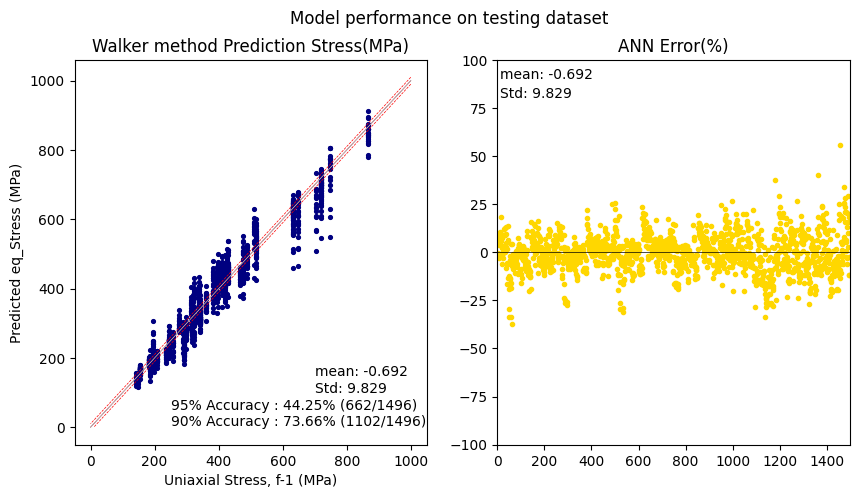

In [15]:
with torch.no_grad():
    output = model(x_test_tensor)
    output = output.to('cpu')  
    
Y_pred = output.detach().numpy()

prediction = pd.DataFrame(Y_pred, columns = ['Y_pred'])
prediction['f-1'] = np.array(test_y)
prediction['error(%)'] = ((prediction['Y_pred']-prediction['f-1'])/prediction['f-1'])*100

temp_error = prediction['error(%)']
filtered_data5 = temp_error[(temp_error >= -5) & (temp_error <= 5)]
filtered_data10 = temp_error[(temp_error >= -10) & (temp_error <= 10)]

fig_3, axs = plt.subplots(1, 2, figsize=(10, 5))
fig_3.suptitle('Model performance on testing dataset')
axs[0].scatter(prediction['f-1'], prediction['Y_pred'], s=30 , marker='.', color='navy')
axs[0].plot([1000,0],[1000,0],'-',color='black', linewidth=0.5)
axs[0].set_title("Walker method Prediction Stress(MPa)")
axs[0].text(700,150,f"mean: {prediction['error(%)'].mean():.3f}",fontsize=10)
axs[0].text(700,100,f"Std: {prediction['error(%)'].std():.3f}",fontsize=10)
axs[0].set(xlabel='Uniaxial Stress, f-1 (MPa)', ylabel='Predicted eq_Stress (MPa)')
axs[0].plot([1000,0],[1000,0],'-',color='pink', linewidth=0.5)
axs[0].plot([1000,0],[1010,10],'--',color='red', linewidth=0.5)
axs[0].plot([1000,10],[990,0],'--',color='red', linewidth=0.5)
axs[0].text(250,50,f"95% Accuracy : {filtered_data5.count()/test_x.shape[0]*100:.2f}% ({filtered_data5.count()}/{test_x.shape[0]})",fontsize=10)
axs[0].text(250,5,f"90% Accuracy : {filtered_data10.count()/test_x.shape[0]*100:.2f}% ({filtered_data10.count()}/{test_x.shape[0]})",fontsize=10)

axs[1].plot(prediction['error(%)'] ,'.', color='gold')
axs[1].plot([0,1700],[0,0],'-',color='black', linewidth=0.5)
axs[1].set_xlim([0, test_y.shape[0]])
axs[1].set_ylim([-100, 100])
axs[1].set_title("ANN Error(%)")
axs[1].text(10,90,f"mean: {prediction['error(%)'].mean():.3f}",fontsize=10)
axs[1].text(10,80,f"Std: {prediction['error(%)'].std():.3f}",fontsize=10)

print(prediction.describe())

In [7]:
Lamda = [0, 1e-2, 1e-1, 1e0, 1e1]

stati_std = np.zeros((len(Lamda),len(Lamda)))
stati_mean = np.zeros((len(Lamda),len(Lamda)))
i = 0

for L1 in (Lamda):
    for L2 in (Lamda):
        
        i += 1

        seed = 777
        torch.manual_seed(seed)

        lossesNN = []
        lossesPhy = []
        total_losses = []

        kf = KFold(n_splits = 6, shuffle=True, random_state=seed)
        results = []

        for fold, (train_index, val_index) in enumerate(kf.split(x_train_tensor)):
            print(f"FOLD {fold + 1} ",end='')

            X_train, X_val = x_train_tensor[train_index], x_train_tensor[val_index]
            y_train, y_val = y_train_tensor[train_index], y_train_tensor[val_index]
            y__phy_train, y_phy_val = Physic_tensor[train_index], Physic_tensor[val_index]

            model = NeuralNetwork(23, 1).to('cuda')
            loss = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

            epochs = 1000
            for epoch in range(epochs):
                model.train()
                optimizer.zero_grad()
                Se_pred = model(X_train.to('cuda'))

                loss1 = loss(Se_pred, y_train.to('cuda'))
                loss2 = loss(Se_pred, y__phy_train.to('cuda'))
                total_loss = L1*loss1 + L2*loss2

                lossesNN.append(loss1.item())
                lossesPhy.append(loss2.item())
                #loss1.backward(retain_graph=True)
                total_loss.backward(retain_graph=True)
                optimizer.step()

            if (epoch+1) % 100 == 0:
                print(f'\rcase {i} of {len(Lamda)**2} Epoch [{epoch+1}/{epochs}], Loss: {total_loss.item():.2f} NNL: {loss1.item():.2f}, PHYL: {loss2.item():.2f}', end=' ')
        
        with torch.no_grad():
            output = model(x_test_tensor)
            output = output.to('cpu')
        Y_pred = output.detach().numpy()

        pred = pd.DataFrame(Y_pred, columns = ['Y_pred'])
        pred['f-1'] = np.array(test_y)
        pred['error(%)'] = ((pred['Y_pred']-pred['f-1'])/pred['f-1'])*100
        error = np.array(pred['error(%)'])
        
        stati_std[Lamda.index(L1),Lamda.index(L2)] = np.std(error, ddof=1)
        stati_mean[Lamda.index(L1),Lamda.index(L2)] = np.mean(error)
    
        print(f'[ANN:{L1}, PHY:{L2}] - Std:{np.std(error, ddof=1):.2f} - mean:{np.mean(error):.2f}')

        #Y_pred = pd.DataFrame(np.array(Y_pred), columns = ['Y_pred'])
        #print(Y_pred.describe())

case 1 of 25 Epoch [1000/1000], Loss: 0.00 NNL: 187643.75, PHYL: 223555.81 [ANN:0, PHY:0] - Std:0.06 - mean:-99.90
case 2 of 25 Epoch [1000/1000], Loss: 0.62 NNL: 9437.12, PHYL: 62.09 [ANN:0, PHY:0.01] - Std:20.92 - mean:10.06
case 3 of 25 Epoch [1000/1000], Loss: 6.36 NNL: 9443.09, PHYL: 63.62 [ANN:0, PHY:0.1] - Std:20.96 - mean:10.08
case 4 of 25 Epoch [1000/1000], Loss: 73.31 NNL: 9419.17, PHYL: 73.31 [ANN:0, PHY:1.0] - Std:20.89 - mean:10.23
case 5 of 25 Epoch [1000/1000], Loss: 727.25 NNL: 9443.81, PHYL: 72.73 [ANN:0, PHY:10.0] - Std:20.89 - mean:10.07
case 6 of 25 Epoch [1000/1000], Loss: 0.41 NNL: 40.56, PHYL: 9487.35 [ANN:0.01, PHY:0] - Std:10.13 - mean:-1.34
case 7 of 25 Epoch [1000/1000], Loss: 48.21 NNL: 2367.31, PHYL: 2453.80 [ANN:0.01, PHY:0.01] - Std:14.45 - mean:4.50
case 8 of 25 Epoch [1000/1000], Loss: 95.03 NNL: 7771.83, PHYL: 173.12 [ANN:0.01, PHY:0.1] - Std:20.02 - mean:9.40
case 9 of 25 Epoch [1000/1000], Loss: 190.00 NNL: 9235.40, PHYL: 97.65 [ANN:0.01, PHY:1.0] -

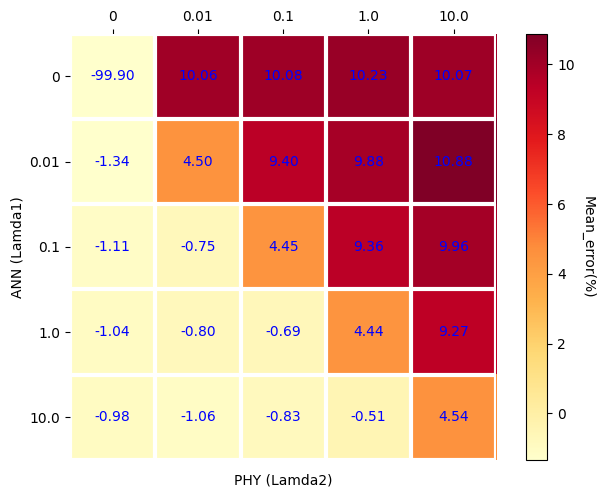

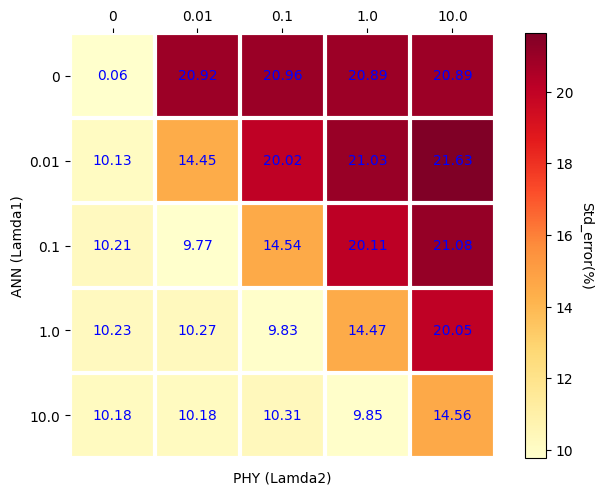

In [8]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar
###########################################################################################
ANN = Lamda
PHY = Lamda

vmin_mean = np.min(stati_mean[1:])
vmax_mean = np.max(stati_mean[1:])

vmin_std = np.min(stati_std[1:])
vmax_std = np.max(stati_std[1:])

figA, ax = plt.subplots()

im, cbar = heatmap(stati_mean, PHY, ANN, ax=ax,
                   cmap="YlOrRd", cbarlabel="Mean_error(%)", vmin = vmin_mean, vmax = vmax_mean)

for i in range(len(ANN)):
    for j in range(len(PHY)):
        text = ax.text(j, i, f'{stati_mean[i, j]:.2f}',ha="center", va="center", color="b")

figA.tight_layout()
plt.xlabel('PHY (Lamda2)',size = 10)
plt.ylabel('ANN (Lamda1)',size = 10)
plt.show()

figB, ax = plt.subplots()

im, cbar = heatmap(stati_std, PHY, ANN, ax=ax,
                   cmap="YlOrRd", cbarlabel="Std_error(%)", vmin = vmin_std, vmax = vmax_std)

for i in range(len(ANN)):
    for j in range(len(PHY)):
        text = ax.text(j, i, f'{stati_std[i, j]:.2f}',ha="center", va="center", color="b")

figB.tight_layout()
plt.xlabel('PHY (Lamda2)',size = 10)
plt.ylabel('ANN (Lamda1)',size = 10)
plt.show()

